# Day 64
I've heard analysts talk about the 2022 NFL Season being boring and/or low scoring. One metric we can look at is win margin, which is calculated as winning team's points - losing team's points. I want to see how the average win margin of games through Week 9 stacks up against previous seasons. If there is a significant difference in close games, maybe that can help to build a case that this NFL season isn't the most entertaining from an offensive standpoint.

## Set Up

In [1]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
import pingouin

# Create database connection
conn = sqlite3.connect('../../data/db/database_test.db')

In [2]:
current_week = 16

## Get the data

In [3]:
query = f"""
WITH data AS (
    SELECT
        season,
        week,
        ABS(result) AS win_margin
    FROM schedules 
    WHERE week <= {current_week}
        AND game_type = 'REG'
        AND away_score IS NOT NULL -- this removes games that have yet to be played
)
SELECT *
FROM data
"""

df = pd.read_sql(query, conn)
df.head()

,season,week,win_margin
0,1999,1,3.0
1,1999,1,3.0
2,1999,1,43.0
3,1999,1,4.0
4,1999,1,17.0


In [4]:
by_season = df.groupby('season').mean()

In [5]:
by_season.sort_values('win_margin', ascending=False).round(2)

,week,win_margin
season,,
2009,8.60,12.75
2014,8.53,12.64
2007,8.60,12.58
2011,8.57,12.14
2021,8.42,12.13
2008,8.63,12.12
2012,8.55,12.06
2017,8.55,11.92
2003,8.63,11.86


In [6]:
by_season.describe()

,week,win_margin
count,24.000000,24.000000
mean,8.562192,11.516944
std,0.066502,0.775844
min,8.408333,9.445833
25%,8.525000,11.116667
50%,8.575054,11.562500
75%,8.608333,12.073958
max,8.662500,12.754167


In [7]:
by_season['win_margin'].quantile(0.25) - (1.5 * stats.iqr(by_season['win_margin']))

9.680729166666667

Based on this the win margin for 2022 is an outlier. At an average of 9.42 points over the first 9 weeks, it's less than the threshold of 1.5 * IQR which is 10.12 pts. It's a small sample but there is a case to believe that the average win margin for 2022 is significantly lower than the typical NFL season.

## Hypothesis Test
To test my hunch, I'll perform a 1-sample T-Test and run a hypothesis test:
- Null Hypothesis: There is no significant difference between the 2022 NFL season win margin and the average win margin among all previous NFL seasons
- Alternate Hypothesis: The average win margin for the 2022 NFL season is lower than the average win margin among all previous NFL seasons

I'll set my alpha to .05.

Because my sample size is small (23 seasons) I'll use the bootstrap method to manufacture a population of NFL games.

In [8]:
query = f"""
WITH data AS (
    SELECT
        season,
        week,
        ABS(result) AS win_margin,
        total AS total_pts,
        overtime AS ot_flag
    FROM schedules 
    WHERE week <= {current_week}
        AND game_type = 'REG'
        AND away_score IS NOT NULL
), aggregation AS (
    SELECT season, AVG(win_margin) AS avg_win_margin
    FROM data
    GROUP BY SEASON
)
SELECT *
FROM aggregation
"""

by_season = pd.read_sql(query, conn)
by_season

,season,avg_win_margin
0,1999,11.236052
1,2000,11.575107
2,2001,10.845494
3,2002,11.129167
4,2003,11.858333
5,2004,11.554167
6,2005,11.570833
7,2006,11.483333
8,2007,12.583333
9,2008,12.120833


In [9]:
# Split dataset
by_season_2022 = by_season[by_season['season'] == 2022]
by_season_1999_2021 = by_season[by_season['season'] < 2022]

print(len(by_season_1999_2021))

23


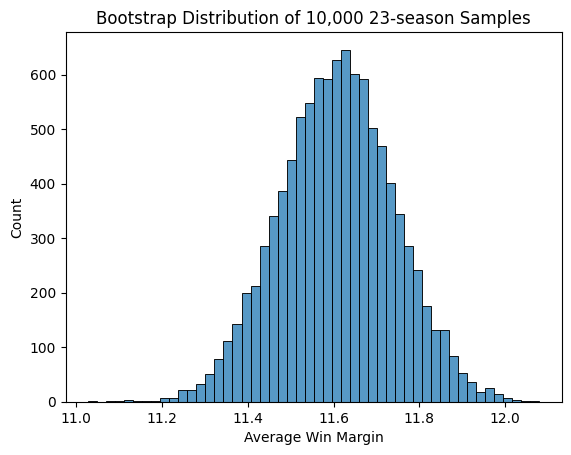

In [10]:
# Get sample means
win_margin_boot_dist = []
for i in range(10000):
	win_margin_boot_dist.append(
		# Get point estimate
		np.mean(
			# Resample
			by_season_1999_2021.sample(frac=1, replace=True)['avg_win_margin']
		)
	)

# Confirm sample means are normally distributed
g = sns.histplot(win_margin_boot_dist, bins=50)
g.set(
	xlabel="Average Win Margin",
	title="Bootstrap Distribution of 10,000 23-season Samples"
)
plt.show()

As expected, the average win margin of the bootstrap population is normally distributed. I'll perform a 1-sample T-Test to either reject or fail to reject the null hypothesis (accept the alt hypothesis).

In [11]:
# Perform 1-sample T-Test
import pingouin

pingouin.ttest(win_margin_boot_dist, by_season_2022['avg_win_margin'].iloc[0], "left")

/Volumes/develop/projects/fantasy_football_analysis/env/lib/python3.10/site-packages/pingouin/parametric.py:227: UserWarning: x and y have unequal sizes. Switching to paired == False. Check your data.
  warnings.warn("x and y have unequal sizes. Switching to paired == False. Check your data.")
/Volumes/develop/projects/fantasy_football_analysis/env/lib/python3.10/site-packages/pingouin/bayesian.py:152: RuntimeWarning: divide by zero encountered in double_scalars
  bf10 = 1 / ((1 + t**2 / df) ** (-(df + 1) / 2) / integr)


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,1621.609414,9999,two-sided,0.0,"[11.6, 11.61]",16.216094,inf,1.0


Based on the extremely low p-value, I can reject the null hypothesis and conclude that the average margin of victory through the first 9 weeks of the 2022 NFL season is significantly smaller than the average. I hope to add to this analysis in the future by getting more data from past NFL seasons.

## Scoring Summary by Season
We know that the margin of victory through Week 16 for 2022 is the lowest in the past 24 years. But to make a case for 2022 to be the most **unexicitng** season in recent memory, I want to take a look at the breakdown of scoring opportunities by season.  

I can use the Play-by-Play table and perform some aggregations.

### Query
The first step is to add new columns to the Play-by-Play table and aggregate. These new columns can help determine big, exciting plays in a game. For example, a season with more passing touchdowns over 30 or even 50 yards should be more exciting than a season where most passing touchdowns are only for 10-15 yards.

```sql
CREATE view pbp_summary_xtra_cols AS 
WITH pbp_summary AS (
        WITH all_games AS (
            SELECT DISTINCT game_id, season, week, season_type, posteam AS team
            FROM pbp
            WHERE team IS NOT NULL
                AND team <> ''
            ORDER BY game_id),
        offense AS (
            SELECT
            game_id,
            posteam AS team,
            MAX(CASE WHEN pass_touchdown = 1 THEN yards_gained END) AS max_yds_pass_td,
            AVG(CASE WHEN pass_touchdown = 1 THEN yards_gained END) AS avg_yds_pass_td,
            SUM(CASE WHEN pass_touchdown = 1 AND yards_gained >= 20 THEN 1 END) AS tot_pass_tds_gte_20_yds,
            SUM(CASE WHEN pass_touchdown = 1 AND yards_gained >= 30 THEN 1 END) AS tot_pass_tds_gte_30_yds,
            SUM(CASE WHEN pass_touchdown = 1 AND yards_gained >= 40 THEN 1 END) AS tot_pass_tds_gte_40_yds,
            SUM(CASE WHEN pass_touchdown = 1 AND yards_gained >= 50 THEN 1 END) AS tot_pass_tds_gte_50_yds,
            SUM(pass_touchdown) AS tot_pass_tds,
            MAX(CASE WHEN rush_touchdown = 1 THEN yards_gained END) AS max_yds_rush_td,
            AVG(CASE WHEN rush_touchdown = 1 THEN yards_gained END) AS avg_yds_rush_td,
            SUM(CASE WHEN rush_touchdown = 1 AND yards_gained >= 20 THEN 1 END) AS tot_rush_tds_gte_20_yds,
            SUM(CASE WHEN rush_touchdown = 1 AND yards_gained >= 30 THEN 1 END) AS tot_rush_tds_gte_30_yds,
            SUM(CASE WHEN rush_touchdown = 1 AND yards_gained >= 40 THEN 1 END) AS tot_rush_tds_gte_40_yds,
            SUM(CASE WHEN rush_touchdown = 1 AND yards_gained >= 50 THEN 1 END) AS tot_rush_tds_gte_50_yds,
            SUM(rush_touchdown) AS tot_rush_tds
            FROM pbp
            WHERE team IS NOT NULL and team <> ''
            GROUP BY game_id, team),
        ret_tds AS (
            SELECT 
                game_id, 
                td_team AS team,
                SUM(return_touchdown) AS tot_ret_tds
            FROM pbp
            WHERE return_touchdown = 1 AND td_team = posteam
            GROUP BY game_id, team), 
        extra_pts AS (
            SELECT
                game_id,
                posteam AS team,
                COUNT(*) AS tot_extra_pts
            FROM pbp
            WHERE extra_point_attempt = 1 AND extra_point_result = 'good'
            GROUP BY game_id, posteam),
        field_goals AS (
            SELECT 
                game_id,
                -- Correct for data error in game_id: 2000_11_OAK_DEN
                CASE WHEN game_id = '2000_11_OAK_DEN' 
                    AND desc LIKE '%J.Elam%' 
                    AND desc LIKE '%field goal%' 
                    THEN 'DEN'
                ELSE posteam
                END AS team,
                COUNT(*) AS tot_fgs
            FROM pbp
            WHERE field_goal_attempt = 1 
                AND field_goal_result = 'made'
                AND desc LIKE '%field goal%'
            GROUP BY game_id, team), 
        two_pt_convs AS (
            SELECT 
                game_id,
                posteam AS team,
                COUNT(*) AS tot_2pt_conv
            FROM pbp
            WHERE two_point_attempt = 1 AND two_point_conv_result = 'success'
            GROUP BY game_id, posteam),
        -- Counts defensive TDs and punt/kickoff return TDs
        defense AS (
            SELECT
                game_id,
                td_team AS team,
                COUNT(*) AS tot_def_tds
            FROM pbp
            WHERE touchdown = 1
                AND (
                    defteam_score_post <> defteam_score
                    OR (defteam_score IS NULL AND defteam_score_post >= 6)
                )
            GROUP BY game_id, td_team),
        safeties AS (
            SELECT
                game_id,
                CASE WHEN defteam_score_post <> defteam_score THEN defteam
                ELSE posteam
                END AS team,
                COUNT(*) AS tot_safeties
            FROM pbp
            WHERE safety = 1
            GROUP BY game_id, team),
        def_2pt_att AS (
            SELECT
                game_id,
                defteam AS team,
                COUNT(*) AS tot_def_2pt
            FROM pbp
            WHERE desc LIKE '%DEFENSIVE TWO-POINT ATTEMPT%'
                AND defteam_score_post <> defteam_score
            GROUP BY game_id, team),
        off_fumb_recovery AS (
            SELECT
                game_id,
                posteam AS team,
                COUNT(*) AS tot_off_fumble_recov_td
            FROM pbp
            WHERE desc LIKE '%fumble%'
                AND posteam_score_post <> posteam_score
                AND touchdown = 1
                AND pass_touchdown = 0
                AND rush_touchdown = 0
                AND return_touchdown = 0
            GROUP BY game_id, team),
        joined AS (
            SELECT 
                all_games.*,
                -- offense.*,
                COALESCE(max_yds_pass_td, 0) AS max_yds_pass_td,
                COALESCE(avg_yds_pass_td, 0) AS avg_yds_pass_td,
                COALESCE(tot_pass_tds_gte_20_yds, 0) AS tot_pass_tds_gte_20_yds,
                COALESCE(tot_pass_tds_gte_30_yds, 0) AS tot_pass_tds_gte_30_yds,
                COALESCE(tot_pass_tds_gte_40_yds, 0) AS tot_pass_tds_gte_40_yds,
                COALESCE(tot_pass_tds_gte_50_yds, 0) AS tot_pass_tds_gte_50_yds,
                COALESCE(tot_pass_tds, 0) AS tot_pass_tds,
                COALESCE(max_yds_rush_td, 0) AS max_yds_rush_td,
                COALESCE(avg_yds_rush_td, 0) AS avg_yds_rush_td,
                COALESCE(tot_rush_tds_gte_20_yds, 0) AS tot_rush_tds_gte_20_yds,
                COALESCE(tot_rush_tds_gte_30_yds, 0) AS tot_rush_tds_gte_30_yds,
                COALESCE(tot_rush_tds_gte_40_yds, 0) AS tot_rush_tds_gte_40_yds,
                COALESCE(tot_rush_tds_gte_50_yds, 0) AS tot_rush_tds_gte_50_yds,
                COALESCE(tot_rush_tds, 0) AS tot_rush_tds,
                COALESCE(tot_ret_tds, 0) AS tot_ret_tds,
                COALESCE(tot_extra_pts, 0) AS tot_extra_pts,
                COALESCE(tot_fgs, 0) AS tot_fgs,
                COALESCE(tot_2pt_conv, 0) AS tot_2pt_conv,
                COALESCE(tot_def_tds, 0) AS tot_def_tds,
                COALESCE(tot_safeties, 0) AS tot_safeties,
                COALESCE(tot_def_2pt, 0) AS tot_def_2pt,
                COALESCE(tot_off_fumble_recov_td, 0) AS tot_off_fumble_recov_td
            FROM all_games
            LEFT JOIN offense
                ON offense.game_id = all_games.game_id
                    AND offense.team = all_games.team
            LEFT JOIN ret_tds
                ON ret_tds.game_id = all_games.game_id
                    AND ret_tds.team = all_games.team  
            LEFT JOIN extra_pts
                ON extra_pts.game_id = all_games.game_id
                    AND extra_pts.team = all_games.team
            LEFT JOIN field_goals
                ON field_goals.game_id = all_games.game_id
                    AND field_goals.team = all_games.team
            LEFT JOIN two_pt_convs
                ON two_pt_convs.game_id = all_games.game_id
                    AND two_pt_convs.team = all_games.team
            LEFT JOIN defense
                ON defense.game_id = all_games.game_id
                    AND defense.team = all_games.team
            LEFT JOIN safeties
                ON safeties.game_id = all_games.game_id
                    AND safeties.team = all_games.team
            LEFT JOIN def_2pt_att
                ON def_2pt_att.game_id = all_games.game_id
                    AND def_2pt_att.team = all_games.team
            LEFT JOIN off_fumb_recovery
                ON off_fumb_recovery.game_id = all_games.game_id
                    AND off_fumb_recovery.team = all_games.team
        )
        SELECT *,
            (tot_pass_tds * 6
            + tot_rush_tds * 6
            + tot_ret_tds * 6
            + tot_extra_pts * 1
            + tot_fgs * 3
            + tot_2pt_conv * 2
            + tot_def_tds * 6
            + tot_safeties * 2
            + tot_def_2pt * 2
            + tot_off_fumble_recov_td * 6) AS score,
            -- Use old team abbrev. that matches game_id for teams that moved (pbp data has new names)
            CASE
                WHEN game_id LIKE '%OAK%' AND team = 'LV' THEN 'OAK'
                WHEN game_id LIKE '%SD%' AND team = 'LAC' THEN 'SD'
                WHEN game_id LIKE '%STL%' AND team = 'LA' THEN 'STL'
                ELSE team
            END AS team_fixed
        FROM joined
    ), sched AS (
        WITH home_games AS (
            SELECT
                game_id,
                season,
                week,
                game_type,
                home_team AS team,
                home_score AS score
            FROM schedules
            WHERE week <= 16
        ), away_games AS (
            SELECT
                game_id,
                season,
                week,
                game_type,
                away_team AS team,
                away_score AS score
            FROM schedules
            WHERE week <= 16
        )
        -- Stack the data
        SELECT *
        FROM home_games
        UNION ALL
        SELECT *
        FROM away_games
    )
    SELECT
        sched.game_id,
        sched.team,
        sched.score AS sched_score,
        pbp_summary.score AS pbp_score,
        (sched.score - pbp_summary.score) AS score_diff,
        max_yds_pass_td,
        ROUND(avg_yds_pass_td, 2) AS avg_yds_pass_td,
        tot_pass_tds_gte_20_yds,
        tot_pass_tds_gte_30_yds,
        tot_pass_tds_gte_40_yds,
        tot_pass_tds_gte_50_yds,
        tot_pass_tds,
        max_yds_rush_td,
        ROUND(avg_yds_rush_td, 2) AS avg_yds_rush_td,
        tot_rush_tds_gte_20_yds,
        tot_rush_tds_gte_30_yds,
        tot_rush_tds_gte_40_yds,
        tot_rush_tds_gte_50_yds,
        tot_rush_tds,
        tot_ret_tds,
        tot_extra_pts,
        tot_fgs,
        tot_2pt_conv,
        tot_def_tds,
        tot_safeties,
        tot_def_2pt,
        tot_off_fumble_recov_td
    FROM sched
    LEFT JOIN pbp_summary
        ON pbp_summary.game_id = sched.game_id
        AND pbp_summary.team_fixed = sched.team
;
```

The next step is to use this table (saved as a view) and aggregate further on the season-level. I want to utilize *window functions* like `RANK()` and `N_TILE()` to group seasons by quantile and then rank them by those quantiles.

```sql
SELECT
    *,
    NTILE(5) OVER(ORDER BY avg_score DESC) AS score_quantile,
    NTILE(5) OVER(ORDER BY avg_fgs ASC) AS fg_quantile,
    NTILE(5) OVER(ORDER BY avg_pass_tds_gte_30_yds DESC) AS pass_td_gte_30yds_quantile,
    NTILE(5) OVER(ORDER BY avg_max_yds_pass_td DESC) AS avg_max_yds_pass_td_quantile
FROM
(WITH data_table AS (
    SELECT
        SUBSTR(game_id, 1, 4) AS season,
        SUBSTR(game_id, 6, 2) AS week,
        *
    FROM pbp_summary_xtra_cols
    WHERE pbp_score IS NOT NULL    
)
SELECT
    season,
    ROUND(AVG(tot_fgs), 3) AS avg_fgs,
    ROUND(AVG(pbp_score), 3) AS avg_score,
    -- ROUND(AVG(tot_pass_tds), 3) AS avg_pass_tds,
    ROUND(AVG(tot_pass_tds_gte_30_yds), 3) AS avg_pass_tds_gte_30_yds,
    ROUND(AVG(max_yds_pass_td), 3) AS avg_max_yds_pass_td
    -- ROUND(AVG(avg_yds_pass_td), 3) AS avg_yds_pass_td,
    -- ROUND(AVG(tot_rush_tds), 3) AS avg_rush_tds,
    -- ROUND(AVG(max_yds_rush_td), 3) AS avg_max_yds_rush_td,
    -- ROUND(AVG(avg_yds_rush_td), 3) AS avg_yds_rush_td,
    -- ROUND(AVG(tot_rush_tds_gte_30_yds), 3) AS avg_rush_tds_gte_30_yds,
    -- ROUND(AVG(tot_ret_tds), 3) AS avg_ret_tds,
    -- ROUND(AVG(tot_def_tds), 3) AS avg_def_tds
FROM data_table
GROUP BY season)
ORDER BY fg_quantile, score_quantile, pass_td_gte_30yds_quantile, avg_max_yds_pass_td_quantile
;
```

### Result
| season | avg_fgs | avg_score | avg_pass_tds_gte_30_yds | avg_max_yds_pass_td | score_quantile | fg_quantile | pass_td_gte_30yds_quantile | avg_max_yds_pass_td_quantile |
| :----- | :------ | :-------- | :---------------------- | :------------------ | :------------- | :---------- | :------------------------- | :--------------------------- |
| 2002   | 1.44    | 21.798    | 0.3                     | 19.6                | 3              | 1           | 4                          | 3                            |
| 2009   | 1.471   | 21.49     | 0.327                   | 20.01               | 4              | 1           | 2                          | 3                            |
| 2004   | 1.371   | 21.506    | 0.325                   | 18.856              | 4              | 1           | 2                          | 4                            |
| 2000   | 1.485   | 20.563    | 0.316                   | 18.613              | 5              | 1           | 3                          | 5                            |
| 2001   | 1.479   | 20.247    | 0.296                   | 19.212              | 5              | 1           | 4                          | 4                            |
| 2019   | 1.546   | 22.76     | 0.333                   | 20.473              | 2              | 2           | 2                          | 2                            |
| 1999   | 1.522   | 20.653    | 0.353                   | 21.427              | 4              | 2           | 1                          | 2                            |
| 2003   | 1.488   | 20.971    | 0.323                   | 20.419              | 4              | 2           | 3                          | 2                            |
| 2006   | 1.488   | 20.504    | 0.329                   | 19.244              | 5              | 2           | 2                          | 4                            |
| 2005   | 1.519   | 20.527    | 0.281                   | 18.621              | 5              | 2           | 5                          | 5                            |
| 2018   | 1.585   | 23.388    | 0.356                   | 22.104              | 1              | 3           | 1                          | 1                            |
| 2020   | 1.594   | 24.696    | 0.294                   | 20.235              | 1              | 3           | 4                          | 3                            |
| 2021   | 1.585   | 22.829    | 0.269                   | 18.773              | 1              | 3           | 5                          | 4                            |
| 2010   | 1.565   | 22.248    | 0.338                   | 21.548              | 2              | 3           | 1                          | 1                            |
| 2007   | 1.552   | 21.492    | 0.298                   | 18.367              | 4              | 3           | 4                          | 5                            |
| 2015   | 1.617   | 22.902    | 0.342                   | 23.021              | 1              | 4           | 1                          | 1                            |
| 2014   | 1.617   | 22.717    | 0.342                   | 22.115              | 2              | 4           | 1                          | 1                            |
| 2011   | 1.629   | 22.077    | 0.323                   | 21.494              | 3              | 4           | 3                          | 2                            |
| 2008   | 1.671   | 22.006    | 0.283                   | 18.794              | 3              | 4           | 5                          | 4                            |
| 2022   | 1.671   | 21.973    | 0.269                   | 17.56               | 3              | 4           | 5                          | 5                            |
| 2013   | 1.692   | 23.588    | 0.323                   | 21.769              | 1              | 5           | 3                          | 1                            |
| 2016   | 1.675   | 22.775    | 0.329                   | 20.69               | 2              | 5           | 2                          | 2                            |
| 2012   | 1.685   | 22.738    | 0.313                   | 20.119              | 2              | 5           | 3                          | 3                            |
| 2017   | 1.704   | 21.858    | 0.288                   | 19.833              | 3              | 5           | 4                          | 3                            |
